# SETUP

In [98]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer, compute_per_channel_dice
from os import listdir
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet
import torch
from astropy.io import fits
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap


Properties of pre-trained model

In [2]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=1
inChannels=1
terminal_show_freq=50
model='VNET'
opt='sgd'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}

save = ('./' + model + '_checkpoints/' + model + '_', dataset_name)[0]

Load pre-trained model

In [135]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=2
        self.cuda = False
        self.pretrained = pretrained
        self.dataset_name = 'hi_source'
        self.save = './inference_checkpoints/' + self.model + '_checkpoints/' + self.model + '_' + self.dataset_name
args = argsclass('VNET', 'adam', 1e-2, 1, 1, "../../VNET_checkpoints/VNET_/VNET__BEST.pth")
model, optimizer = create_model(args)
criterion = DiceLoss(classes=args.classes)
model.restore_checkpoint(args.pretrained)

Building Model . . . . . . . .VNET
VNET Number of params: 45603934


2

In [4]:
train_df = pd.read_csv("../../VNET_checkpoints/VNET_/train.csv", header=None, sep=" ", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../../VNET_checkpoints/VNET_/val.csv", header=None, sep=" ", names=["skip", "epoch", "loss", "dsc"])

In [5]:
val_df["loss"] = val_df.loss.str.split(":", expand=True)[1]
train_df["loss"] = train_df.loss.str.split(":", expand=True)[1]
val_df["dsc"] = val_df.dsc.str.split(":", expand=True)[1]
train_df["dsc"] = train_df.dsc.str.split(":", expand=True)[1]
train_df = train_df[['epoch', 'loss', 'dsc']]
val_df = val_df[['epoch', 'loss', 'dsc']]

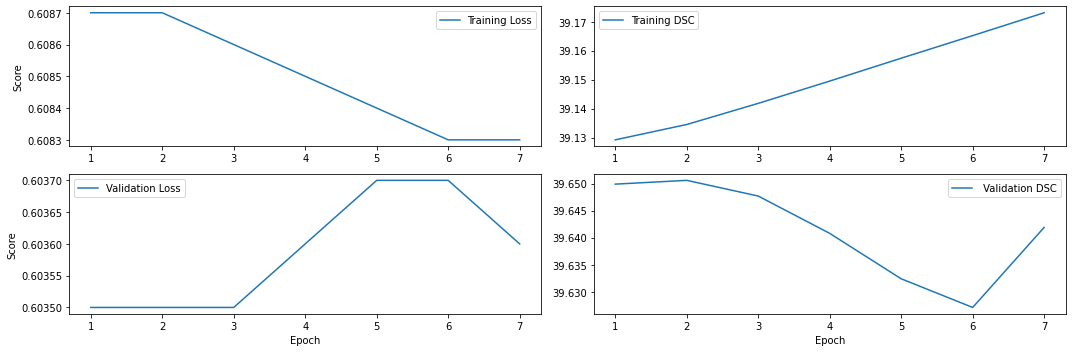

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (15, 5))

axes[0][0].plot(train_df.epoch, train_df.loss.astype(float), label="Training Loss")
axes[0][1].plot(train_df.epoch, train_df.dsc.astype(float), label="Training DSC")
axes[1][0].plot(val_df.epoch, val_df.loss.astype(float), label="Validation Loss")
axes[1][1].plot(val_df.epoch, val_df.dsc.astype(float), label=" Validation DSC")

axes[1][0].set_xlabel("Epoch")
axes[1][1].set_xlabel("Epoch")
axes[0][0].set_ylabel("Score")
axes[1][0].set_ylabel("Score")
axes[0][0].legend()
axes[1][0].legend()
axes[1][1].legend()
axes[0][1].legend()
fig.tight_layout()

Load the test subcubes

In [26]:
def prepare_data(data):
    interval = ZScaleInterval()
    return interval(np.nan_to_num(np.moveaxis(data, 0, 2)))

In [ ]:
model.eval()
for file in listdir("../data/testing/Input/"):
    if "noisefree_" in file:
        print(file)
        orig_data = fits.getdata("../data/testing/Input/"+file)[:64, :128, :128]
        prepared_data = prepare_data(orig_data)
        realseg_data = fits.getdata("../data/testing/Target/mask_"+file.split("_")[-1])[:64, :128, :128]

        data_loader_tensor = torch.FloatTensor(prepared_data.astype(np.float32)).unsqueeze(0)[None, ...]
        with torch.no_grad():
            out_cube = model.inference(data_loader_tensor)

        loss_dice, per_ch_score = criterion(out_cube, torch.FloatTensor(np.moveaxis(realseg_data, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...])
        print(loss_dice)
        fig, axes = plt.subplots(1, 4, figsize=(10, 10))
        axes[0].imshow(orig_data[1])
        axes[1].imshow(prepared_data[..., 1])
        axes[2].imshow(realseg_data[1])
        axes[3].imshow(out_cube.squeeze()[..., 1])
        plt.show()

In [80]:
model.eval()
orig_data = fits.getdata("../data/testing/loud_1245mosC.fits")[230:294, 200:200+128, 300:300+128]
prepared_data = prepare_data(orig_data)
realseg_data = fits.getdata("../data/testing/mask_1245mosC.fits")[230:294, 200:200+128, 300:300+128]
mask_tensor = torch.FloatTensor(np.moveaxis(realseg_data, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
data_loader_tensor = torch.FloatTensor(prepared_data.astype(np.float32)).unsqueeze(0)[None, ...]
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
    out_mask = model.inference(mask_tensor)

loss_dice, per_ch_score = criterion(out_cube, mask_tensor)
print(loss_dice)

tensor(0.5884)


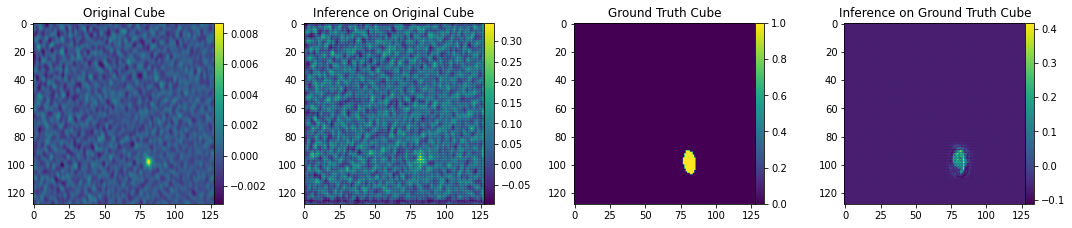

In [131]:
fig, axes = plt.subplots(1, 4, figsize = (15, 5))
im0 = axes[0].imshow(orig_data[34])
cax0 = make_axes_locatable(axes[0]).append_axes("right", size="5%",pad=0)
fig.colorbar(im0, cax=cax0)
axes[0].set_title("Original Cube")

im1 = axes[1].imshow(out_cube.squeeze()[0][..., 34])
cax1 = make_axes_locatable(axes[1]).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
axes[1].set_title("Inference on Original Cube")

im2 = axes[2].imshow(realseg_data[34])
cax2 = make_axes_locatable(axes[2]).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
axes[2].set_title("Ground Truth Cube")

im3 = axes[3].imshow(out_mask.squeeze()[0][..., 34])
cax3 = make_axes_locatable(axes[3]).append_axes("right", size="5%",pad=0)
fig.colorbar(im3, cax=cax3)
axes[3].set_title("Inference on Ground Truth Cube")

fig.tight_layout()